In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Section 1: Setup**

In [2]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


In [56]:
# !pip install google-adk
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

print("ADK components imported successfully.")


ADK components imported successfully.


In [4]:
retry_config=types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429,500,503,504]
)

## **Model Context Protocol**


## **Using MCP with Your Agent**

The workflow is simple:

- Choose an MCP Server and tool
- Create the MCP Toolset (configure connection)
- Add it to your agent
- Run and test the agent
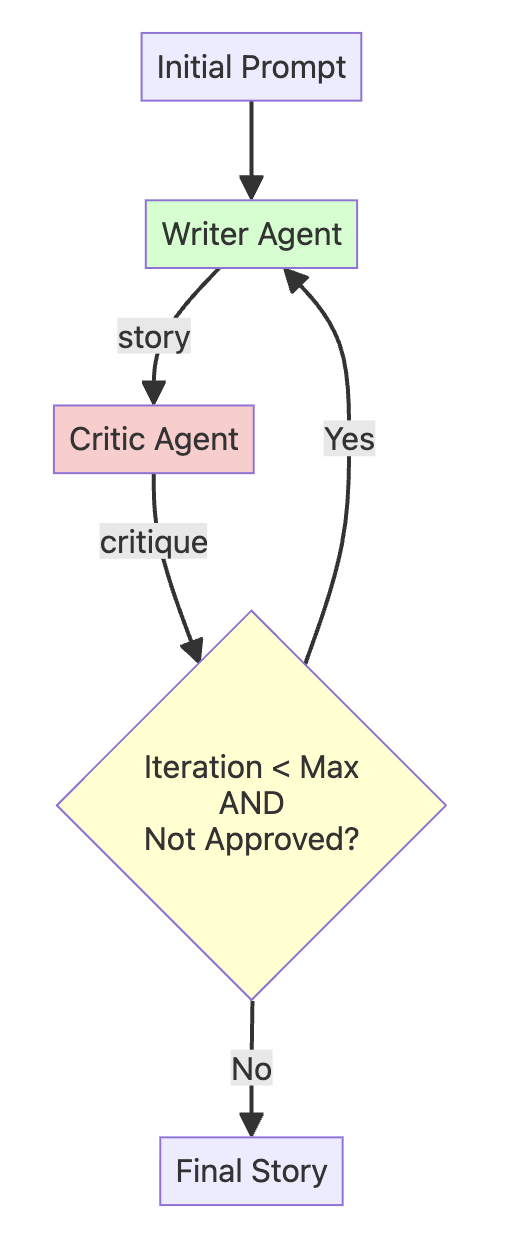
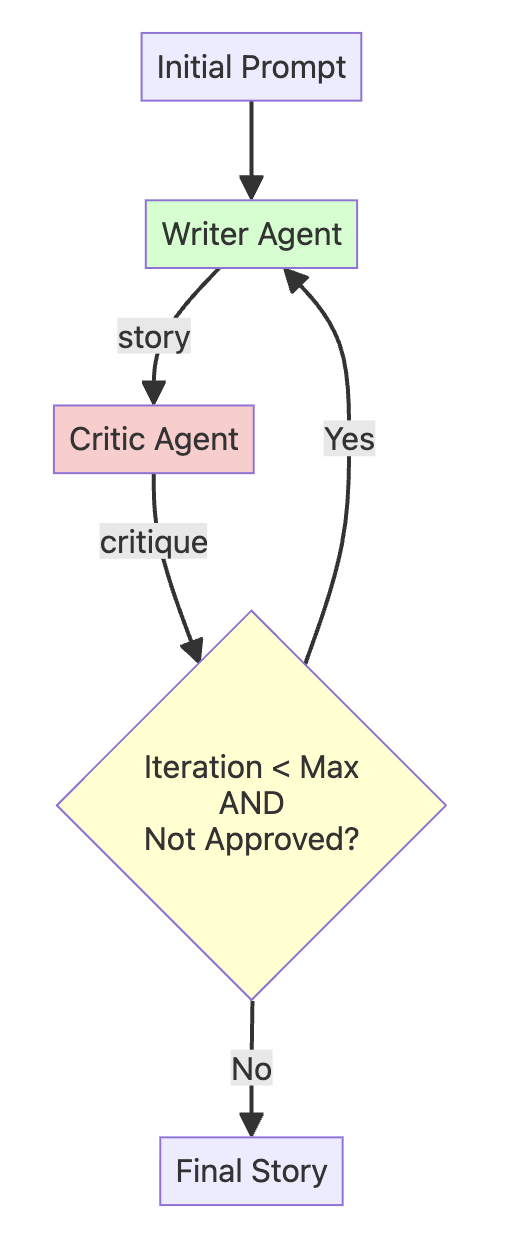
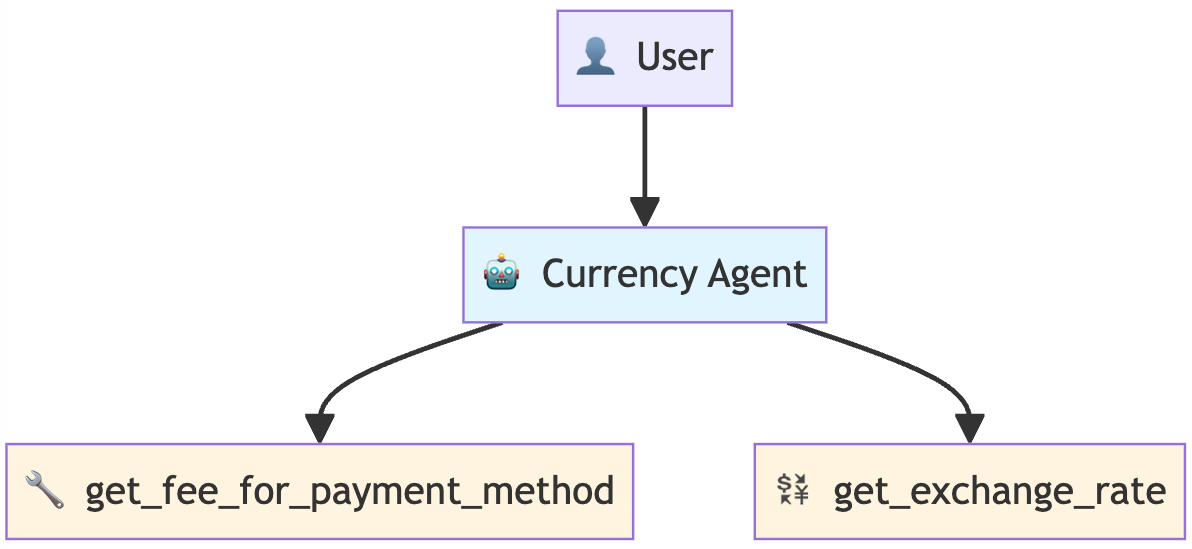
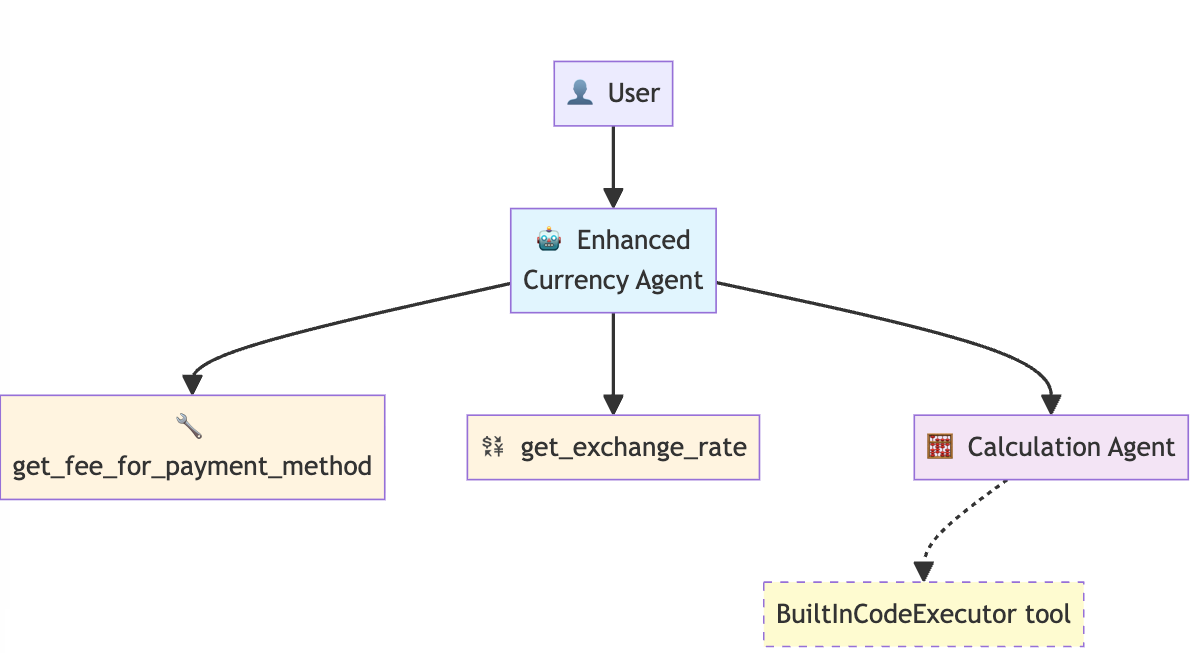
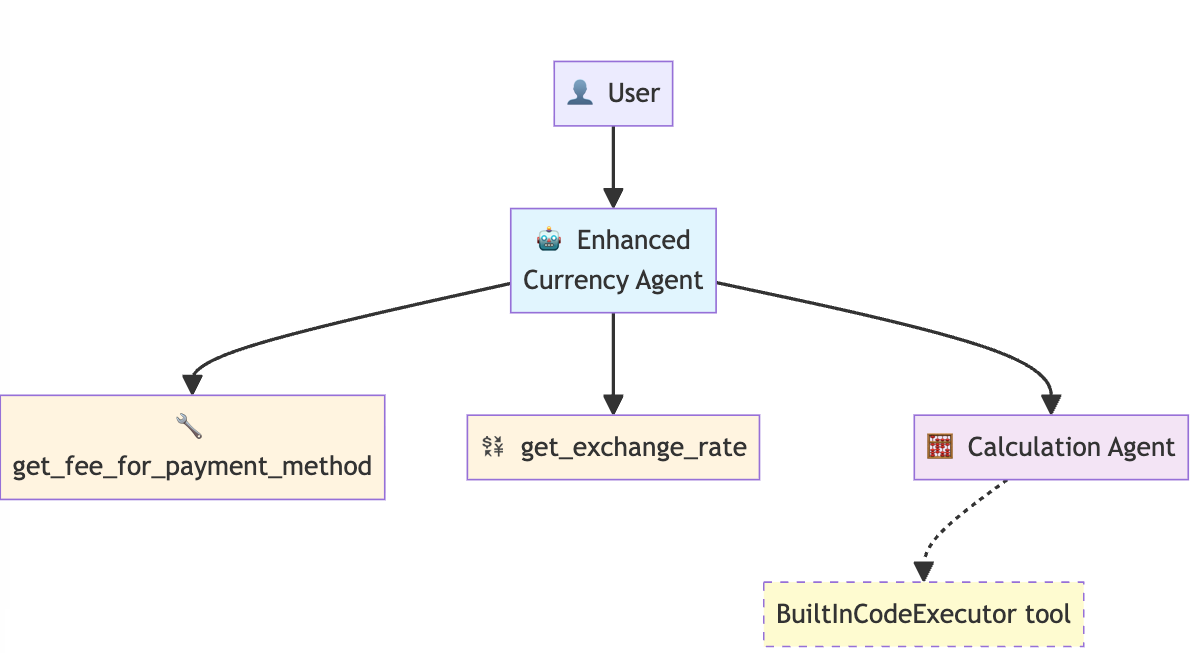

### MCP Working

MCP connects your agent (the **client**) to external **MCP servers** that provide tools:

- **MCP Server**: Provides specific tools (like image generation, database access)
- **MCP Client**: Your agent that uses those tools
- **All servers work the same way** - standardized interface

**Architecture:**
```
┌──────────────────┐
│   Your Agent     │
│   (MCP Client)   │
└────────┬─────────┘
         │
         │ Standard MCP Protocol
         │
    ┌────┴────┬────────┬────────┐
    │         │        │        │
    ▼         ▼        ▼        ▼
┌────────┐ ┌─────┐ ┌──────┐ ┌─────┐
│ GitHub │ │Slack│ │ Maps │ │ ... │
│ Server │ │ MCP │ │ MCP  │ │     │
└────────┘ └─────┘ └──────┘ └─────┘
```

In [52]:
# Create the MCP Toolset:::
# MCP integration with Everything Server
# an npm package (@modelcontextprotocol/server-everything) designed for testing MCP integrations.
# It provides a getTinyImage tool that returns a simple test image (16x16 pixels, Base64-encoded). Find more servers: modelcontextprotocol.io/examples
# NOTE: This is a demo server to learn MCP. In production, you'll use servers for Google Maps, Slack, Discord, etc.

mcp_image_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="npx",  # Run MCP server via npx
            args=[
                "-y",  # Argument for npx to auto-confirm install
                "@modelcontextprotocol/server-everything",
            ],
            tool_filter=["getTinyImage"],
        ),
        timeout=30
    )
)

print(" MCP Tool created")

 MCP Tool created


#### **Behind the scenes:**
1. **Server Launch**: ADK runs `npx -y @modelcontextprotocol/server-everything`
2. **Handshake**: Establishes stdio communication channel
3. **Tool Discovery**: Server tells ADK: "I provide getTinyImage" functionality
4. **Integration**: Tools appear in agent's tool list automatically
5. **Execution**: When agent calls `getTinyImage()`, ADK forwards to MCP server
6. **Response**: Server result is returned to agent seamlessly

**Why This Matters**: You get instant access to tools without writing integration code!

In [55]:
#  Add MCP tool to agent:::
# Create image agent with MCP integration

image_agent=LlmAgent(
    name="ImageAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""Use the MCP Tool to generate images for user queries""",
    tools=[mcp_image_server]
)

print("Image Agent is created..")

Image Agent is created..


In [57]:
runner = InMemoryRunner(agent=image_agent)
response = await runner.run_debug(
    "Provide a sample tiny image", 
    verbose=True
)


 ### Created new session: debug_session_id

User > Provide a sample tiny image


/usr/local/lib/python3.11/dist-packages/google/adk/tools/mcp_tool/mcp_tool.py:101: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(


ImageAgent > [Calling tool: getTinyImage({})]
ImageAgent > [Tool result: {'content': [{'type': 'text', 'text': 'This is a tiny image:'}, {'type': 'image', 'data': 'iVBORw0KG...]
ImageAgent > This is a tiny image:
This is a tiny image.


## Display the image:

- The server returns base64-encoded image data. Let's decode and display it:

In [91]:
from IPython.display import display, Image as IPImage
import base64

for event in response:
    if event.content and event.content.parts:
        for part in event.content.parts:
            if hasattr(part, "function_response") and part.function_response:
                for item in part.function_response.response.get("content", []):
                    if item.get("type") == "image":
                        display(IPImage(data=base64.b64decode(item["data"])))

3


### Extending to Other MCP Servers

The same pattern works for any MCP server - only the connection_params change. Here are some examples:

#### kaggle

- Kaggle MCP Server - For dataset and notebook operations
Kaggle provides an MCP server that lets your agents interact with Kaggle datasets, notebooks, and competitions.
- What it provides:
  * 📊 Search and download Kaggle datasets
  * 📓 Access notebook metadata
  * 🏆 Query competition information etc.,
- **Learn more:** [Kaggle MCP Documentation](https://www.kaggle.com/docs/mcp)

#### Github
- For PR/Issue analysis
- **More resources:** [ADK Third-party Tools Documentation](https://google.github.io/adk-docs/tools/third-party/)

# Connection example:
# for Kaggle
```python
kaggle_mcp_server=McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command='npx',
            args=[
                '-y',
                'mcp-remote',
                'https://www.kaggle.com/mcp'
            ],
        ),
        timeout=30,
    )
)
```
# for github

```python
McpToolset(
    connection_params=StreamableHTTPServerParams(
        url="https://api.githubcopilot.com/mcp/",
        headers={
            "Authorization": f"Bearer {GITHUB_TOKEN}",
            "X-MCP-Toolsets": "all",
            "X-MCP-Readonly": "true"
        },
    ),
)
```